In [1]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from matplotlib import pyplot as plt

In [2]:
def read_files(path):
    dataset = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), encoding = 'utf-8') as f:
            line = f.read().replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
            dataset.append(re.sub(r'\s+', ' ', line))
    return dataset


In [3]:
# Загрузка датасета
train_bad = read_files('malicious_pure')
train_valid = read_files('powershell_benign_dataset')
test_bad = read_files('test_ds_bad')
test_valid = read_files('test_ds_valid')

# Объединяем массивы в единые датасеты
train_ds = train_bad + train_valid
test_ds = test_bad + test_valid
# Создаем массивы с метками
# 1 - malicious
# 0 - clean
y_train_bad = [1 for i in range(0, len(train_bad))]
y_train_valid = [0 for i in range(0, len(train_valid))]
y_train = y_train_bad + y_train_valid
y_test_bad = [1 for i in range(0, len(test_bad))]
y_test_valid = [0 for i in range(0, len(test_valid))]
y_test = y_test_bad + y_test_valid

In [4]:
def clean_data_to_tokens(dataset):
    tokens = []
    char_replace = "()[]{},;'/\=:^<>|`+\""
    for source_string in dataset:
        source_string = re.sub(r"FromBase64String\(\'(.*)\'\)", "base64_string", source_string)
        source_string = re.sub(r"([a-zA-Z0-9\/\+=]{100,})+", "base64_string", source_string)
        for char in char_replace:
            source_string = source_string.replace(char, ' ')
        source_string = re.sub(r"(?<!\S)\d+(?!\S)", " ", source_string)
        source_string = re.sub(r"0x\S+", " ", source_string)
        ip_addresses = re.findall(r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)', source_string)
        for ip in ip_addresses:
            if ip.startswith('10.') or ip.startswith('192.') or ip.startswith('172.16.') or ip.startswith('127.0.'):
                source_string = source_string.replace(ip, 'internal_ip')
            else:
                source_string = source_string.replace(ip, 'external_ip')
        source_string = source_string.replace('.', ' ')
        tokens.append(re.sub(r'\s+', ' ', source_string.lower()))
    return tokens
# Обрабатываем данные
train_token_ds = clean_data_to_tokens(train_ds)
test_token_ds = clean_data_to_tokens(test_ds)

In [5]:
# Вывод статистики по датасету
def dataset_info(input_data):
    sent_lens = [len(sentence.split()) for sentence in input_data]
    avg_sent_len = np.mean(sent_lens)
    max_token_len = max([len(sentence.split()) for sentence in input_data])
    print('Средняя длинна в токенах: ', avg_sent_len) 
    print('Максимальная длинна в токенах: ', max_token_len)
    output_seq_len_95 = int(np.percentile(sent_lens, 95))
    print('Количество токенов в строке покрывающих 95% всех строк: ', output_seq_len_95)
    output_seq_len_97 = int (np. percentile(sent_lens, 97))
    print('Количество токенов в строке покрывающих 97% всех строк: ', output_seq_len_97)
    output_seq_len_99 = int(np.percentile(sent_lens, 99))
    print('Количество токенов в строке покрывающих 99% всех строк: ', output_seq_len_99)

# Cловарь с уникальными токенами
def dataset_vocab(input_data):
    unique_words = {}
    for data in input_data:
        words = data.split()
        for word in words:
            if word not in unique_words:
                unique_words[word] = 1
            else:
                unique_words[word] += 1
    # Сортируем словарь от большего к меньшему
    sorted_unique_words = {k:v for k,v in sorted(unique_words.items(), key=lambda item: item[1], reverse=True)}
    # Ограничение на вывод первых 100 элементов словаря
    sorted_unique_words = dict(list(sorted_unique_words.items())[:100])
    unique_words_count = len(unique_words.keys())
    print('Словарь уникальных токенов в исходных данных (Токен:Количество): \n', sorted_unique_words)
    print('Количество уникальных токенов в исходных данных: ', unique_words_count)
# Выводим статистику по тренировочному датасету
print('Информация по данным тренировочного датасета') 
dataset_info(train_token_ds)
dataset_vocab(train_token_ds)   

Информация по данным тренировочного датасета
Средняя длинна в токенах:  308.24035108813274
Максимальная длинна в токенах:  29572
Количество токенов в строке покрывающих 95% всех строк:  1062
Количество токенов в строке покрывающих 97% всех строк:  1589
Количество токенов в строке покрывающих 99% всех строк:  4862
Словарь уникальных токенов в исходных данных (Токен:Количество): 
 {'if': 34879, 'intptr': 28896, 'system': 25967, '-name': 24352, '@': 22685, 'should': 20640, 'assert-areequal': 19074, 'name': 16596, '$': 15566, '$true': 15117, 'string': 14727, '-eq': 14585, '$i': 14420, '$_': 14063, 'uint': 13883, 'public': 13361, 'function': 13285, 'parameter': 12130, 'new-object': 11594, '-resourcegroupname': 10698, '$rgname': 10264, '-path': 10211, 'count': 9904, '$false': 9785, '$null': 9614, 'the': 9500, 'else': 9493, 'it': 9493, 'length': 9291, 'dll': 8864, 'to': 8728, '$z': 8676, 'for': 8622, 'mandatory': 8083, '$result': 8047, 'out-null': 7968, 'param': 7784, 'byte': 7721, '$w': 7691

In [6]:
# Функция обрезает строки в массиве до количества токенов max_token_count
def truncate_string(input_data, max_token_count):
  for index in range(len(input_data)):
    token_count = len(input_data[index].split())
    if token_count > max_token_count:
      input_data[index] = ' '.join(input_data[index].split()[:max_token_count])
  return input_data
max_token = 2000 # Значение в токенах покрывающее ~97% всех строк
train_token_ds = truncate_string(train_token_ds, max_token)
test_token_ds = truncate_string(test_token_ds, max_token)

In [7]:
# Разделяем тренировочный датасет на 2 части (для тренировки и валидации) в пропорции 80х20
train_tokens, val_tokens, train_labels, val_labels = train_test_split(train_token_ds, y_train, test_size=0.2, random_state=42)
# Отдельно сохраняем валидационные метки, далее будем использовать для тестирования модели.
val_labels_encoded = val_labels
# Кодируем метки OneHotEncoder
train_labels = pd.DataFrame(train_labels)
val_labels = pd.DataFrame(val_labels)
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels = one_hot_encoder.fit_transform(train_labels.to_numpy().reshape(-1, 1))
val_labels = one_hot_encoder.transform(val_labels.to_numpy().reshape(-1, 1))
# Формируем датасеты для тренировки, валидации и проверки
train_dataset = tf.data.Dataset.from_tensor_slices((train_tokens, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_tokens, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_token_ds))
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [8]:
max_tokens_count = 90000 # Максимальный размер словаря нашего датасета ~91000 мы возьмем ТОП самых часто встречающихся токенов
# Создадим слой TextVectorization
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens_count, # Максимальный размер словаря
                                           output_sequence_length=max_token, # максимальное количество токенов
                                           standardize=None) # Не используем стандартизацию т.к. уже преобразовали данные
text_vectorizer.adapt(train_tokens) # Формирование словаря

In [9]:
token_embed = layers.Embedding(input_dim=max_tokens_count, # Максимальный размер словаря
                               output_dim=16, # Количество эмбеддингов
                               mask_zero=True)

In [10]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # Слой TextVectorization
token_embeddings = token_embed(text_vectors) # Слой Embedding
model = layers.Convolution1D(32, kernel_size=32, padding="same",activation="relu")(token_embeddings)
model = layers.MaxPooling1D(pool_size=(2))(model)
model = layers.Bidirectional(layers.LSTM(16))(model)
outputs = layers.Dense(2, activation="softmax")(model)
model_pwsh = tf.keras.Model(inputs, outputs)

In [11]:
model_pwsh.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   metrics=["accuracy"])
print(model_pwsh.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 2000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 2000, 16)          1440000   
                                                                 
 conv1d (Conv1D)             (None, 2000, 32)          16416     
                                                                 
 max_pooling1d (MaxPooling1  (None, 1000, 32)          0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 32)                6272  

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_pwsh',
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [13]:
model_history = model_pwsh.fit(train_dataset,
                              epochs=15,
                              validation_data=val_dataset,
                              callbacks=[checkpoint])

Epoch 1/15
416/416 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.9137INFO:tensorflow:Assets written to: model_pwsh\assets


INFO:tensorflow:Assets written to: model_pwsh\assets


416/416 [==============================] - 93s 217ms/step - loss: 0.3996 - accuracy: 0.9137 - val_loss: 0.1046 - val_accuracy: 0.9820
Epoch 2/15
416/416 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9814INFO:tensorflow:Assets written to: model_pwsh\assets


INFO:tensorflow:Assets written to: model_pwsh\assets


416/416 [==============================] - 90s 216ms/step - loss: 0.0821 - accuracy: 0.9814 - val_loss: 0.0629 - val_accuracy: 0.9850
Epoch 3/15
416/416 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9886INFO:tensorflow:Assets written to: model_pwsh\assets


INFO:tensorflow:Assets written to: model_pwsh\assets


416/416 [==============================] - 91s 218ms/step - loss: 0.0470 - accuracy: 0.9886 - val_loss: 0.0461 - val_accuracy: 0.9874
Epoch 4/15
416/416 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9928INFO:tensorflow:Assets written to: model_pwsh\assets


INFO:tensorflow:Assets written to: model_pwsh\assets


416/416 [==============================] - 94s 225ms/step - loss: 0.0319 - accuracy: 0.9928 - val_loss: 0.0415 - val_accuracy: 0.9886
Epoch 5/15
416/416 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9946INFO:tensorflow:Assets written to: model_pwsh\assets


INFO:tensorflow:Assets written to: model_pwsh\assets


416/416 [==============================] - 96s 231ms/step - loss: 0.0251 - accuracy: 0.9946 - val_loss: 0.0388 - val_accuracy: 0.9892
Epoch 6/15
416/416 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9952INFO:tensorflow:Assets written to: model_pwsh\assets


INFO:tensorflow:Assets written to: model_pwsh\assets


416/416 [==============================] - 93s 223ms/step - loss: 0.0205 - accuracy: 0.9952 - val_loss: 0.0345 - val_accuracy: 0.9904
Epoch 7/15
416/416 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9962INFO:tensorflow:Assets written to: model_pwsh\assets


INFO:tensorflow:Assets written to: model_pwsh\assets


416/416 [==============================] - 94s 226ms/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.0334 - val_accuracy: 0.9910
Epoch 8/15
416/416 [==============================] - 95s 228ms/step - loss: 0.0121 - accuracy: 0.9968 - val_loss: 0.0344 - val_accuracy: 0.9892
Epoch 9/15
416/416 [==============================] - 92s 222ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.0341 - val_accuracy: 0.9892
Epoch 10/15
416/416 [==============================] - 92s 221ms/step - loss: 0.0080 - accuracy: 0.9974 - val_loss: 0.0355 - val_accuracy: 0.9898
Epoch 11/15
416/416 [==============================] - 92s 221ms/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 0.0380 - val_accuracy: 0.9898
Epoch 12/15
416/416 [==============================] - 92s 222ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0380 - val_accuracy: 0.9898
Epoch 13/15
416/416 [==============================] - 93s 223ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.0383 - val_accuracy:

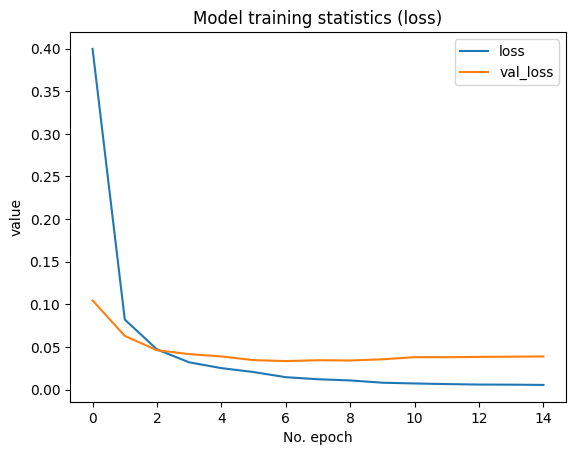

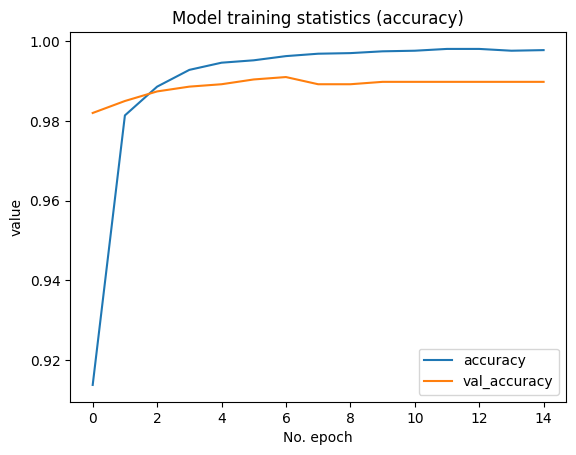

In [15]:
# Loss
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.title('Model training statistics (loss)')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
# Accuracy
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label='val_accuracy')
plt.title('Model training statistics (accuracy)')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Функция для подготовки результатов обучения модели
def calculate_results(y_true, y_pred):
  # Расчет accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Расчет precision, recall, f1
  model_precision, model_recall, model_f1, support = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Загрузка модели
test_model = tf.keras.models.load_model("model_pwsh")
# Тестирование модели
print('Тестирование модели на неизвестных данных')
# Получение результатов работы модели на тестовом датасете
model_test_probs = test_model.predict(test_dataset)
# Конвертация результатов в классы
model_test_preds = tf.argmax(model_test_probs, axis=1)
# Расчет результатов
model_test_results = calculate_results(y_true=y_test,
                                       y_pred=model_test_preds)
print('Результаты тестирования: \n',model_test_results)

print('Тестирование модели на валидационных данных')
model_test_probs = test_model.predict(val_dataset)
model_test_preds = tf.argmax(model_test_probs, axis=1)
model_test_results = calculate_results(y_true=val_labels_encoded,
                                       y_pred=model_test_preds)
print('Результаты тестирования: \n',model_test_results)

Тестирование модели на неизвестных данных
13/13 [==============================] - 1s 41ms/step
Результаты тестирования: 
 {'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Тестирование модели на валидационных данных
104/104 [==============================] - 5s 41ms/step
Результаты тестирования: 
 {'accuracy': 99.0985576923077, 'precision': 0.9910031801234124, 'recall': 0.9909855769230769, 'f1': 0.9909854304167056}
